<a href="https://colab.research.google.com/github/Kryptera-K/MMM-CCI-Channel-Break-Momentum-Strategy/blob/main/MMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "MMM"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("MMM_clean.csv", index=False)
df

/tmp/ipython-input-3789294982.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,19.426920,19.864347,19.362593,19.774290,2599386
2000-01-04,18.655001,19.516990,18.655001,19.118158,3245705
2000-01-05,19.195351,19.812894,18.757923,18.757923,4424482
2000-01-06,20.739206,21.099441,19.414059,19.414059,7147057
2000-01-07,21.150900,21.369615,20.571953,20.816397,4905035
...,...,...,...,...,...
2025-09-26,152.809998,154.500000,152.369995,154.020004,2104000
2025-09-29,154.080002,154.399994,152.539993,153.500000,2043400
2025-09-30,155.179993,155.220001,152.429993,153.850006,2177100


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

CCI_LEVEL = 0
CCI_PERIOD = 14
DI_PERIOD = 14
DI_SHIFT_1 = 5
KC_MULTIPLIER = 2
KC_PERIOD = 20
WOODIE_CCI_PERIOD = 14
WOODIE_SLOW_PERIOD = 34

# -------------------------
# Indicator Functions
# -------------------------

def cci_lower_than(df, period=CCI_PERIOD, level=CCI_LEVEL):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return df['CCI_main'] < level


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def woodies_trend_down(df, period=WOODIE_SLOW_PERIOD):
    df['CCI_trend'] = calculate_woodie_cci(df, period)['CCI']
    return df['CCI_trend'] < 0


def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def kc_open_above_upper(df):
    df = calculate_keltner_channel(df)
    return df['Open'] > df['KC_Upper']


def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    """
    Calculate Keltner Channel (Mid, Upper, Lower) and ATR.
    """
    df = df.copy()

    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # EMA of Typical Price
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    # True Range and ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Upper and Lower Bands
    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def di_minus_is_rising(df, shift=DI_SHIFT_1):
    df = calculate_di(df)
    return df['DI-'] > df['DI-'].shift(shift)


def calculate_di(df, period=DI_PERIOD):
    """
    Calculate DI+ and DI- indicators.
    """
    df = df.copy()

    # True Range
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    # +DM and -DM
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    # Wilder’s smoothing
    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    # DI+ and DI-
    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])

    return df



# -------------------------
# Entry conditions
# -------------------------

df["CCI_Lower_Than_Level"] = cci_lower_than(df)
df["Woodies_Trend_Down"] = woodies_trend_down(df)

# -------------------------
# Exit conditions
# -------------------------

df["KC_Open_Above_Upper"] = kc_open_above_upper(df)
df["DI-_Is_Rising"] = di_minus_is_rising(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'CCI_Lower_Than_Level',
    'Woodies_Trend_Down',
]
exit_conditions = [
    'KC_Open_Above_Upper',
    'DI-_Is_Rising',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-10-02 00:00:00
Period                                6477 days 00:00:00
Start Value                                     100000.0
End Value                                 1292853.120383
Total Return [%]                              1192.85312
Benchmark Return [%]                          695.275059
Max Gross Exposure [%]                             100.0
Total Fees Paid                             49445.525221
Max Drawdown [%]                               49.806281
Max Drawdown Duration                 1198 days 00:00:00
Total Trades                                          50
Total Closed Trades                                   49
Total Open Trades                                      1
Open Trade PnL                              61671.948654
Win Rate [%]                                   79.591837
Best Trade [%]                                 26.360829
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-02 00:00:00
Period                         6477 days 00:00:00
Start Value                              100000.0
End Value                           795275.059391
Total Return [%]                       695.275059
Benchmark Return [%]                   695.275059
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        58.887124
Max Drawdown Duration          1930 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      695275.059391
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-159895971.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


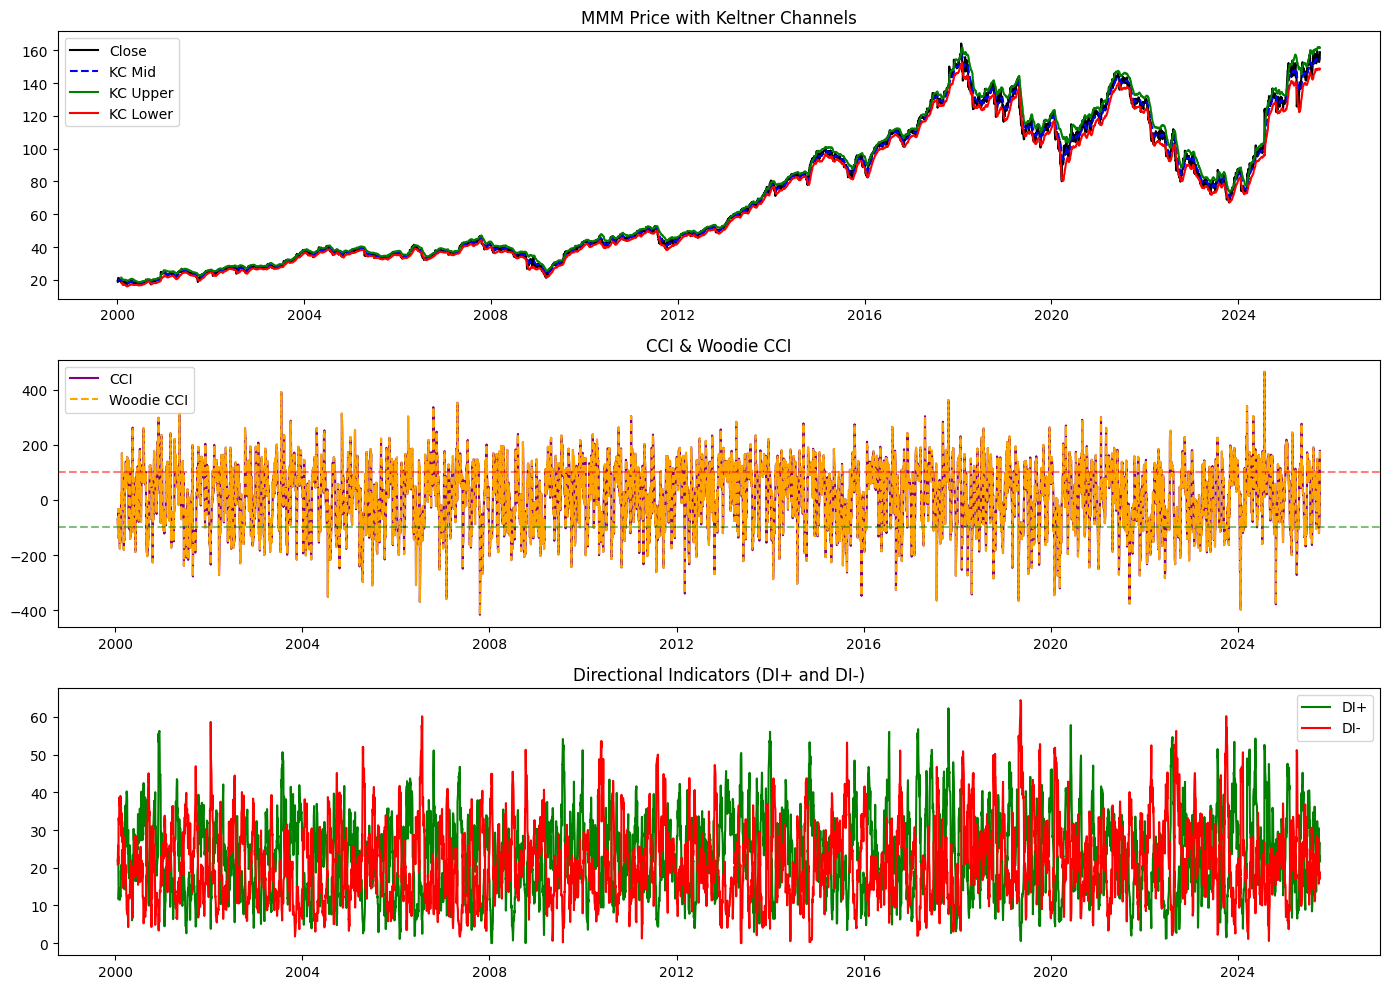

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "MMM"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
CCI_PERIOD = 14
KC_PERIOD = 20
KC_MULTIPLIER = 2
DI_PERIOD = 14
WOODIE_CCI_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------
def calculate_cci(df, period=CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    df = calculate_cci(df, period)
    df['Woodie_CCI'] = df['CCI']
    return df

def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']
    return df

def calculate_di(df, period=DI_PERIOD):
    df = df.copy()
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                         np.maximum(df['High'] - df['High'].shift(1), 0), 0)
    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                         np.maximum(df['Low'].shift(1) - df['Low'], 0), 0)

    df['TR_smooth'] = df['TR'].rolling(period).sum()
    df['+DM_smooth'] = df['+DM'].rolling(period).sum()
    df['-DM_smooth'] = df['-DM'].rolling(period).sum()

    df['DI+'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
    df['DI-'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
    return df

# -------------------------
# Apply Indicators
# -------------------------
df = calculate_cci(df)
df = calculate_woodie_cci(df)
df = calculate_keltner_channel(df)
df = calculate_di(df)

# -------------------------
# Plotting
# -------------------------
plt.figure(figsize=(14,10))

# 1. Price with Keltner Channels
plt.subplot(3,1,1)
plt.plot(df['Close'], label="Close", color='black')
plt.plot(df['KC_Mid'], label="KC Mid", color='blue', linestyle="--")
plt.plot(df['KC_Upper'], label="KC Upper", color='green')
plt.plot(df['KC_Lower'], label="KC Lower", color='red')
plt.title(f"{symbol} Price with Keltner Channels")
plt.legend()

# 2. CCI and Woodie CCI
plt.subplot(3,1,2)
plt.plot(df['CCI'], label="CCI", color='purple')
plt.plot(df['Woodie_CCI'], label="Woodie CCI", color='orange', linestyle="--")
plt.axhline(100, color='red', linestyle="--", alpha=0.5)
plt.axhline(-100, color='green', linestyle="--", alpha=0.5)
plt.title("CCI & Woodie CCI")
plt.legend()

# 3. DI+ and DI-
plt.subplot(3,1,3)
plt.plot(df['DI+'], label="DI+", color='green')
plt.plot(df['DI-'], label="DI-", color='red')
plt.title("Directional Indicators (DI+ and DI-)")
plt.legend()

plt.tight_layout()
plt.show()
